In [1]:
import torch
torch.cuda.empty_cache() 

In [2]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [3]:
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100000"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
os.getcwd()

'/home/yelhe/script/mt'

In [4]:
import glob
import shapely
from shapely.geometry import Polygon
import shapely.plotting

In [5]:
import pandas as pd
from PIL import Image as ima
import warnings

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Add function def show_anns (borrowed from one of the Jupyter notebooks).
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    # polygons = []
    # color = []
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    # for ann in sorted_anns:
    #     m = ann['segmentation']
    #     img = np.ones((m.shape[0], m.shape[1], 3))
    #     color_mask = np.random.random((1, 3)).tolist()[0]
    #     for i in range(3):
    #         img[:,:,i] = color_mask[i]
    #     ax.imshow(np.dstack((img, m*0.35)))

81


<function matplotlib.pyplot.show(close=None, block=None)>

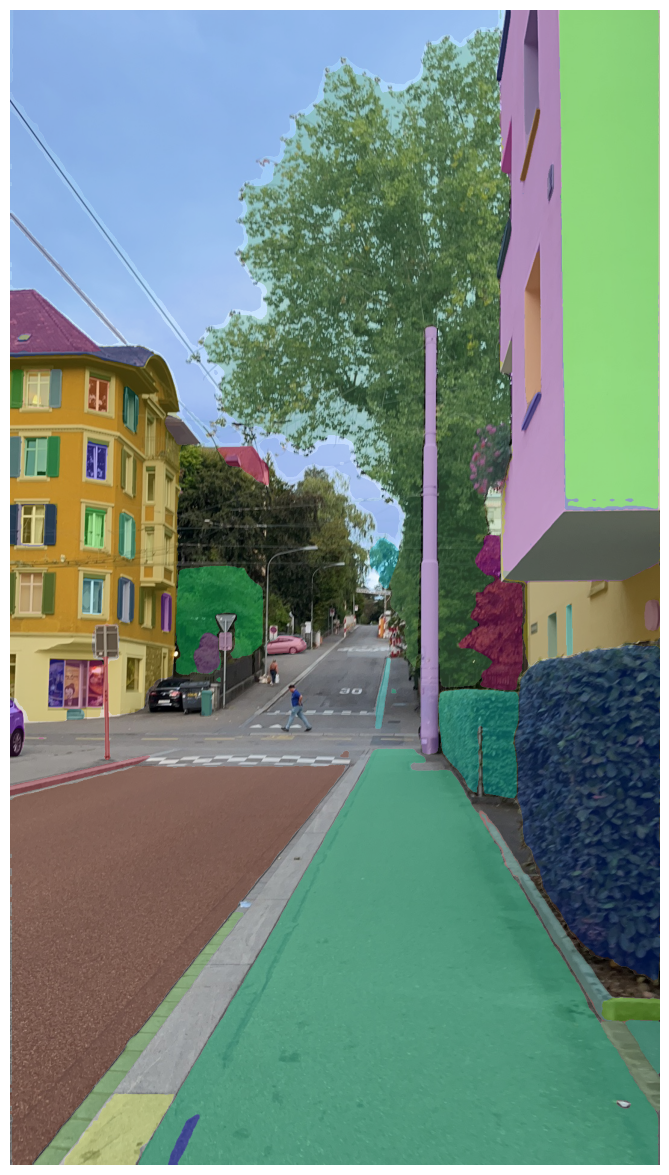

In [14]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="/home/yelhe/data/sam/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
image4 = cv2.imread("/home/yelhe/data/fig/04.jpg")
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
masks4 = mask_generator.generate(image4)
print(len(masks4))
plt.figure(figsize = (15,15))
plt.imshow(image4)
show_anns(masks4)
plt.axis('off')
plt.show

In [15]:
def convert_mask(masks):
    mb01 = []
    mb02 = []
    mb = []
    n = len(masks)
    for i in range(0, n):
        mb01.append(masks[i]['segmentation'])
    for i in range(0, n):
        mb02.append(mb01[i]*1)
    for i in range(0, n):
        mb.append(mb02[i].astype('uint8'))
    return mb

In [16]:
# mask_converted_04 = convert_mask(masks4)
# np.save('/home/yelhe/script/mt/output/mask04.npy', mask_converted_04, allow_pickle=True)


In [17]:
mb = np.load('/home/yelhe/script/mt/output/mask04.npy', allow_pickle=True)

In [18]:
# Function to find and plot filtered contours (find-filter-plot-contour)
def ffpcontour(image, mask, i):
    image_masked = cv2.bitwise_and(image,image,mask = mask[i])
    assert image is not None, "image file could not be read, check with os.path.exists()"
    assert mask is not None, "mask file could not be read, check with os.path.exists()"
    # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 1:
        contour_f = contours
    else:
        contour_f = []
        for i in range(0, len(contours)):
            # print(i, "len", len(contours[i]))
            if len(contours[i]) > 80:
                contour_f.append(contours[i])
    # print("filtered", "len", len(contour_f), contour_f)
    # Plotting the filtered contour
    # -1 is the contourIdx, (0,255,0) is color, 3 is the thickness
    # print("raw",len(contours))
    # print("filtered", len(contour_f))
    img_con = cv2.drawContours(image_masked, contour_f, -1, (0,255,0), 3) 
    plt.figure(figsize = (15,15))
    plt.imshow(img_con)
    plt.axis('on')
    plt.show
    return contour_f

# Function to find and plot filtered contours (find-filter-plot-contour)
def ffpcontour_noplot(image, mask, i):
    assert image is not None, "image file could not be read, check with os.path.exists()"
    assert mask is not None, "mask file could not be read, check with os.path.exists()"
    # imgray = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    ret, thresh = cv2.threshold((mask[i]*255), 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ll = [] # length list
    for i in range(0, len(contours)):
          ll.append(len(contours[i]))
    maxl = max(ll)
    maxindex = ll.index(maxl)
    if (len(contours) == 1):
        contour_f = contours
    # elif (maxl < 80):
    #      contour_f = contours[maxindex]
    else:
        contour_f = []
        for i in range(0, len(contours)):
            # print(i, "len", len(contours[i]))
            if (len(contours[i]) >= 80):
                contour_f.append(contours[i])
            else:
                contour_f = contour_f
        # print("filtered", "len", len(contour_f), contour_f) 
    # print("raw",len(contours))
    # print("filtered", len(contour_f))
    return contour_f

In [19]:
leng = []
for i in range(0,80):
    leng.append(len(ffpcontour_noplot(image4, mb, i)))
print(leng)

[1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


In [21]:
ret, thresh = cv2.threshold((mb[78]*255), 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ll = [] # length list
for i in range(0, len(contours)):
    ll.append(len(contours[i]))
maxl = max(ll)
maxindex = ll.index(maxl)
print(maxl)
print(maxindex)
print(ll)
print(len(contours))


80
0
[80]
1


In [22]:
# a = ffpcontour_noplot(image4, mb, 77)
# ll = [] # length list
# for i in range(0, len(a)):
#     ll.append(len(a[i]))
# maxl = np.max(ll)
# maxindex = ll.index(maxl)

In [23]:
# print(maxl)
# print(maxindex)
# print(ll)
# print(a[maxindex])

In [24]:
# Contour geometric attributes result
# For each contour
def cgr(contour):
    assert contour is not None, "image file could not be read, check with os.path.exists()"
    c = contour
    isconvex = cv2.isContourConvex(c) # Checking convexity
    (x,y), (w,h), ar = cv2.minAreaRect(c) # Rotated rectangle with minimum area
    M = cv2.moments(c) # Moments
    area = cv2.contourArea(c) # Area 
    if (M['m00'] != 0):
        cx = int(M['m10']/M['m00']) # Centroid
        cy = int(M['m01']/M['m00'])
    else:
        cx = x
        cy = y
    xs,ys,ws,hs = cv2.boundingRect(c) # Straight bounding rectangle
    aspect_ratio_wh_s = float(ws)/hs # Aspect ratio
    extent_s = float(area)/(ws*hs) # Extent
    hull = cv2.convexHull(c) # Solidity
    hull_area = cv2.contourArea(hull)
    if (hull_area != 0):
        solidity = float(area)/hull_area
    else:
        solidity = 0
    aspect_ratio_wh = float(w)/h  # Aspect ratio
    extent = float(area)/(w*h) # Extent
    (xe,ye),(MA,ma),ae = cv2.fitEllipse(c)
    ed = np.sqrt(4*area/np.pi) # Equivalent Diameter
    ratio_ell = float(ma)/MA
    perimeter = cv2.arcLength(c, True) # Arclength
    p_centroid = np.array([float(cx), float(cy)])
    p_masscenter = np.array([float(x), float(y)])
    is_cen_inside = cv2.pointPolygonTest(c, p_centroid, False) # Checking if centroid is inside
    is_mce_inside = cv2.pointPolygonTest(c, p_masscenter, False) # Checking if mass center is inside    
    return {
        'isconvex': isconvex,
        'area': area,
        'aspect_ratio_wh_s': aspect_ratio_wh_s,
        'extent_s': extent_s,
        'solidity': solidity,
        'aspect_ratio_wh': aspect_ratio_wh,
        'extent': extent,
        'ed': ed,
        'ratio_ell': ratio_ell,
        'perimeter': perimeter,
        'is_cen_inside': is_cen_inside,
        'is_mce_inside': is_mce_inside
    }
          

In [25]:
def csga(contours):
    assert contours is not None, "image file could not be read, check with os.path.exists()"
    if len(contours) == 1:
        ga = cgr(contours[0])
    else:
        gal = []
        for i in range(0, (len(contours)-1)):
            gal.append(cgr(contours[i]))
        isc = []
        al = []
        asps = []
        exts = []
        sol = []
        asp = []
        ext = []
        ed = []
        rate = []
        per = []
        isc = []
        ism = []
        for i in range(0, len(gal)):
            isc.append(gal[0]['isconvex'])
            al.append(gal[0]['area'])
            asps.append(gal[0]['aspect_ratio_wh_s'])
            exts.append(gal[0]['extent_s'])
            sol.append(gal[0]['solidity'])
            asp.append(gal[0]['aspect_ratio_wh'])
            ext.append(gal[0]['extent'])
            ed.append(gal[0]['ed'])
            rate.append(gal[0]['ratio_ell'])
            per.append(gal[0]['perimeter'])
            isc.append(gal[0]['is_cen_inside'])
            ism.append(gal[0]['is_mce_inside'])
        isconvex = np.all(isc)
        area = np.mean(al, axis = 0)
        aspect_ratio_wh_s = np.mean(asps, axis = 0)
        extent_s = np.mean(exts, axis = 0)
        solidity = np.mean(sol, axis = 0)
        aspect_ratio_wh = np.mean(asp, axis = 0)
        extent = np.mean(ext, axis = 0)
        ed = np.mean(ed, axis = 0)
        ratio_ell = np.mean(rate, axis = 0)
        perimeter = np.mean(per, axis = 0)
        is_cen_inside = np.mean(isc, axis = 0)
        is_mce_inside = np.mean(ism, axis = 0)
        ga = {
            'isconvex': isconvex,
            'area': area,
            'aspect_ratio_wh_s': aspect_ratio_wh_s,
            'extent_s': extent_s,
            'solidity': solidity,
            'aspect_ratio_wh': aspect_ratio_wh,
            'extent': extent,
            'ed': ed,
            'ratio_ell': ratio_ell,
            'perimeter': perimeter,
            'is_cen_inside': is_cen_inside,
            'is_mce_inside': is_mce_inside
        }
    return ga


In [26]:
# mask file mf
def feature_summary(image, mf):
    # Generate a data frame for masks and attributes
    df = pd.DataFrame()
    df['mask'] = range(1, (len(mf)+1))
    df = df.assign(gmedian = None, rmedian = None, bmedian = None,
                   gmean = None, rmean = None, bmean = None,
                   gstd = None, rstd = None, bstd = None,
                   isconvex = None, area = None, aspect_ratio_wh_s = None,
                   extent_s = None, solidity = None, aspect_ratio_wh = None,
                   extent = None, ed = None, ratio_ell = None,
                   perimeter = None, is_cen_inside = None, is_mce_inside = None)
    mm = [] # masked image
    for i in range(0, len(mf)):
        mm.append(cv2.bitwise_and(image, image, mask = mf[i]))
    mib = []
    mig = []
    mir = []
    for i in range(0, len(mm)):
        mib.append((mm[i][:,:,0])[np.where((mm[i][:,:,0]) != 0)])
        mig.append((mm[i][:,:,1])[np.where((mm[i][:,:,1]) != 0)])
        mir.append((mm[i][:,:,2])[np.where((mm[i][:,:,2]) != 0)])
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore", category=RuntimeWarning)
    #     foo = np.nanmean(x, axis=1)
    for i in range(0, len(mm)):
        df.at[i, 'bmean'] = np.mean(mib[i], axis = 0)
        df.at[i,'gmean'] = np.mean(mig[i], axis = 0)
        df.at[i,'rmean'] = np.mean(mir[i], axis = 0)
        df.at[i,'bmedian'] = np.median(mib[i], axis = 0)
        df.at[i,'gmedian'] = np.median(mig[i], axis = 0)
        df.at[i,'rmedian'] = np.median(mir[i], axis = 0)
        df.at[i,'bstd'] = np.std(mib[i], axis = 0)
        df.at[i,'gstd'] = np.std(mig[i], axis = 0)
        df.at[i,'rstd'] = np.std(mir[i], axis = 0)
    for i in range(0, len(mf)):
        df.at[i, 'isconvex'] = csga(ffpcontour_noplot(image, mf, i))['isconvex']
        df.at[i, 'area'] = csga(ffpcontour_noplot(image, mf, i))['area']
        df.at[i, 'aspect_ratio_wh_s'] = csga(ffpcontour_noplot(image, mf, i))['aspect_ratio_wh_s']
        df.at[i, 'extent_s'] = csga(ffpcontour_noplot(image, mf, i))['extent_s']
        df.at[i, 'solidity'] = csga(ffpcontour_noplot(image, mf, i))['solidity']
        df.at[i, 'aspect_ratio_wh'] = csga(ffpcontour_noplot(image, mf, i))['aspect_ratio_wh']
        df.at[i, 'extent'] = csga(ffpcontour_noplot(image, mf, i))['extent']
        df.at[i, 'ed'] = csga(ffpcontour_noplot(image, mf, i))['ed']
        df.at[i, 'ratio_ell'] = csga(ffpcontour_noplot(image, mf, i))['ratio_ell']
        df.at[i, 'perimeter'] = csga(ffpcontour_noplot(image, mf, i))['perimeter']
        df.at[i, 'is_cen_inside'] = csga(ffpcontour_noplot(image, mf, i))['is_cen_inside']
        df.at[i, 'is_mce_inside'] = csga(ffpcontour_noplot(image, mf, i))['is_mce_inside']
    return df

In [27]:
mb.dtype

dtype('uint8')

In [28]:
# df = feature_summary(image4, mb)

In [29]:
# df.to_csv('/home/yelhe/script/mt/output/result4.csv',index = False)

In [30]:
df1 = pd.read_csv('/home/yelhe/script/mt/output/result4.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mask               81 non-null     int64  
 1   gmedian            81 non-null     float64
 2   rmedian            81 non-null     float64
 3   bmedian            81 non-null     float64
 4   gmean              81 non-null     float64
 5   rmean              81 non-null     float64
 6   bmean              81 non-null     float64
 7   gstd               81 non-null     float64
 8   rstd               81 non-null     float64
 9   bstd               81 non-null     float64
 10  isconvex           81 non-null     bool   
 11  area               79 non-null     float64
 12  aspect_ratio_wh_s  79 non-null     float64
 13  extent_s           79 non-null     float64
 14  solidity           79 non-null     float64
 15  aspect_ratio_wh    79 non-null     float64
 16  extent             79 non-nu

In [31]:
df1.head()

,mask,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,...,aspect_ratio_wh_s,extent_s,solidity,aspect_ratio_wh,extent,ed,ratio_ell,perimeter,is_cen_inside,is_mce_inside
0,1,186.0,170.0,191.0,167.813379,151.564383,173.355428,45.145625,41.558144,45.327883,...,0.245646,0.919212,0.957132,4.082397,0.923501,584.982167,4.892309,2725.570629,1.0,1.0
1,2,116.0,116.0,117.0,113.583986,113.548712,114.153470,10.826174,10.608383,11.143132,...,1.246753,0.578373,0.983962,0.801854,0.579880,664.022139,1.716129,2718.601277,1.0,1.0
2,3,51.0,27.0,47.0,51.973771,29.868628,48.186080,26.590183,19.939594,25.117682,...,0.432675,0.800171,0.984627,2.316667,0.804950,369.813254,2.226869,1471.536141,1.0,1.0
3,4,50.0,28.0,46.0,51.411188,30.220114,47.296601,26.208035,19.721085,24.840271,...,0.655357,0.620538,0.923543,1.527322,0.623347,402.964091,3.049564,1906.004175,1.0,1.0
4,5,199.0,244.0,157.0,201.331340,243.751718,161.157723,10.131905,6.840425,13.484687,...,1.368421,0.227345,0.498520,2.784690,0.333976,107.622768,2.293312,828.808218,-0.5,-1.0


In [32]:
df = df1

### Labeling

50


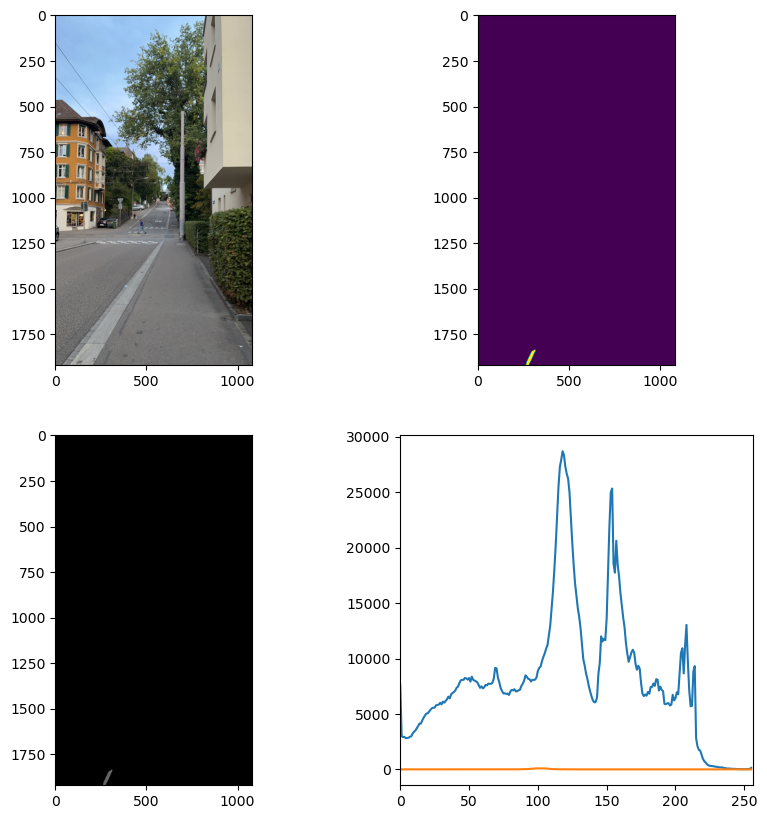

In [198]:
## i = i+1
i = 50
print(i)
img = image4
maskedimg = cv2.bitwise_and(img,img,mask = mb[i])
# create a mask
hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
hist_mask = cv2.calcHist([img],[0],mb[i],[256],[0,256])
plt.figure(figsize = (10,10))
plt.subplot(221), plt.imshow(img)
plt.subplot(222), plt.imshow(mb[i])
plt.subplot(223), plt.imshow(maskedimg)
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])
plt.show()

In [33]:
# Manual Labeling
df = df.assign(label = None)
# df = df.assign(labelgroup = None)

df = df.assign(label = ["building", "pavement", "plant", "plant", "sky", "tree", "building", "building", 
                        "road", "plant", "street_light_pole", "building", "building", "vehicle", "window", "poster", 
                        "window", "pavement_block", "window", "building", "pavement_block", "vehicle", "poster", "curb_block", 
                        "building", "roof", "window", "tree", "window", "window", "roof", "window", 
                        "curb_pavement", "window", "building", "window", "window", "roof", "window", "building", 
                        "vehicle", "window", "window", "plant", "curb_pavement", "roof", "window", "poster", 
                        "building", "roof", "pavement_part", "window", "vehicle", "window", "road_sign", "trash_bin", 
                        
                        "window", "plant", "curb_block", "window", "tree", "curb", "roof", "curb", 
                        "tree", "building", "building", "roof", "window", "window", "building_stairs", "curb_pavement", 
                        "road_sign", "window", "building", "window", "window", "window", "tree", "window", 
                        "street_wire"])

df = df.assign(labelgroup = ["building", "road", "vegetation", "vegetation", "sky", "vegetation", "building", "building", 
                             "road", "vegetation", "infrastructure", "building", "building", "vehicle", "building", "poster", 
                             "building", "curb", "building", "building", "curb", "vehicle", "poster", "curb", 
                             "building", "building", "building", "vegetation", "building", "building", "building", "building", 
                             "curb", "building", "building", "building", "building", "building", "building", "building", 
                             "vehicle", "building", "building", "vegetation", "curb", "building", "building", "poster", 
                             "building", "building", "curb", "building", "vehicle", "building", "infrastructure", "trashbin", 
                             "building", "vegetation", "curb", "building", "vegetation", "curb", "building", "curb", 
                             "vegetation", "building", "building", "building", "building", "building", "building", "curb", 
                             "infrastructure", "building", "building", "building", "building", "building", "vegetation", "building", 
                             "infrastructure"])

In [34]:
# Importing Modules

from sklearn import * 
from sklearn import datasets
from sklearn.datasets import load_digits

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn import linear_model

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn import svm

import seaborn as sn

In [35]:
np.unique(df['labelgroup'])

array(['building', 'curb', 'infrastructure', 'poster', 'road', 'sky',
       'trashbin', 'vegetation', 'vehicle'], dtype=object)

In [36]:
print(df.shape[1])
print(df.shape[0])

24
81


In [37]:
df_new = df.iloc[:, 1:22]

In [38]:
df_new['isconvex'] = df_new['isconvex'].astype(int)

In [39]:
df_new = df_new.astype(float)

In [40]:
df_new.head()

,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,isconvex,...,aspect_ratio_wh_s,extent_s,solidity,aspect_ratio_wh,extent,ed,ratio_ell,perimeter,is_cen_inside,is_mce_inside
0,186.0,170.0,191.0,167.813379,151.564383,173.355428,45.145625,41.558144,45.327883,0.0,...,0.245646,0.919212,0.957132,4.082397,0.923501,584.982167,4.892309,2725.570629,1.0,1.0
1,116.0,116.0,117.0,113.583986,113.548712,114.153470,10.826174,10.608383,11.143132,0.0,...,1.246753,0.578373,0.983962,0.801854,0.579880,664.022139,1.716129,2718.601277,1.0,1.0
2,51.0,27.0,47.0,51.973771,29.868628,48.186080,26.590183,19.939594,25.117682,0.0,...,0.432675,0.800171,0.984627,2.316667,0.804950,369.813254,2.226869,1471.536141,1.0,1.0
3,50.0,28.0,46.0,51.411188,30.220114,47.296601,26.208035,19.721085,24.840271,0.0,...,0.655357,0.620538,0.923543,1.527322,0.623347,402.964091,3.049564,1906.004175,1.0,1.0
4,199.0,244.0,157.0,201.331340,243.751718,161.157723,10.131905,6.840425,13.484687,0.0,...,1.368421,0.227345,0.498520,2.784690,0.333976,107.622768,2.293312,828.808218,-0.5,-1.0


In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gmedian            81 non-null     float64
 1   rmedian            81 non-null     float64
 2   bmedian            81 non-null     float64
 3   gmean              81 non-null     float64
 4   rmean              81 non-null     float64
 5   bmean              81 non-null     float64
 6   gstd               81 non-null     float64
 7   rstd               81 non-null     float64
 8   bstd               81 non-null     float64
 9   isconvex           81 non-null     float64
 10  area               79 non-null     float64
 11  aspect_ratio_wh_s  79 non-null     float64
 12  extent_s           79 non-null     float64
 13  solidity           79 non-null     float64
 14  aspect_ratio_wh    79 non-null     float64
 15  extent             79 non-null     float64
 16  ed                 79 non-nu

In [42]:
df_new.describe()

,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,isconvex,...,aspect_ratio_wh_s,extent_s,solidity,aspect_ratio_wh,extent,ed,ratio_ell,perimeter,is_cen_inside,is_mce_inside
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,103.641975,95.345679,102.660494,104.869708,97.765148,104.222500,34.050792,33.524647,34.851148,0.024691,...,0.674859,0.669316,0.916245,2.518294,0.775251,121.619327,7.179929,626.213587,0.943038,0.873418
std,46.753090,50.961790,47.848839,40.900752,44.816754,41.628377,17.562823,17.873004,18.112780,0.156150,...,0.600501,0.234496,0.112116,4.246812,0.165374,153.498983,17.218758,809.679556,0.299437,0.490083
min,14.000000,19.000000,12.000000,21.247298,24.544286,20.557389,3.662039,3.806177,3.759616,0.000000,...,0.045007,0.052947,0.449939,0.062801,0.256935,24.161547,1.015353,84.384776,-1.000000,-1.000000
25%,69.000000,57.000000,64.000000,74.167873,64.934578,73.014760,19.897768,18.988838,21.124266,0.000000,...,0.283482,0.540160,0.913258,0.482534,0.692640,41.887883,1.963622,181.506096,1.000000,1.000000
50%,86.000000,79.000000,88.000000,100.074510,93.543547,100.415626,32.554990,34.123331,33.655950,0.000000,...,0.529412,0.758285,0.959019,1.368421,0.800862,54.461101,2.813705,251.036578,1.000000,1.000000
75%,139.000000,138.000000,142.000000,133.799767,124.863853,133.764957,48.088899,46.387987,49.110794,0.000000,...,0.771265,0.843792,0.974032,2.903846,0.908219,121.699385,6.123026,668.253352,1.000000,1.000000
max,199.000000,244.000000,206.000000,201.331340,243.751718,205.817519,77.015877,73.666338,76.831176,1.000000,...,3.492537,0.963167,0.990281,28.355892,0.970205,664.022139,142.827512,4539.610507,1.000000,1.000000


In [43]:
df_new_try = df_new.drop(['area', 'ed', 'perimeter'], axis=1)

In [44]:
df_new_try.head()

,gmedian,rmedian,bmedian,gmean,rmean,bmean,gstd,rstd,bstd,isconvex,aspect_ratio_wh_s,extent_s,solidity,aspect_ratio_wh,extent,ratio_ell,is_cen_inside,is_mce_inside
0,186.0,170.0,191.0,167.813379,151.564383,173.355428,45.145625,41.558144,45.327883,0.0,0.245646,0.919212,0.957132,4.082397,0.923501,4.892309,1.0,1.0
1,116.0,116.0,117.0,113.583986,113.548712,114.153470,10.826174,10.608383,11.143132,0.0,1.246753,0.578373,0.983962,0.801854,0.579880,1.716129,1.0,1.0
2,51.0,27.0,47.0,51.973771,29.868628,48.186080,26.590183,19.939594,25.117682,0.0,0.432675,0.800171,0.984627,2.316667,0.804950,2.226869,1.0,1.0
3,50.0,28.0,46.0,51.411188,30.220114,47.296601,26.208035,19.721085,24.840271,0.0,0.655357,0.620538,0.923543,1.527322,0.623347,3.049564,1.0,1.0
4,199.0,244.0,157.0,201.331340,243.751718,161.157723,10.131905,6.840425,13.484687,0.0,1.368421,0.227345,0.498520,2.784690,0.333976,2.293312,-0.5,-1.0


In [45]:
# print(df.loc[[77]])
# print(df.loc[[52]])
df_new_try = df_new_try.drop([52, 77])
# Remove rows with empty values

In [47]:
# df_ = df_new.drop(['area', 'ed', 'perimeter'], axis=1)
df_ = df.drop([52, 77])
le = LabelEncoder()
df_['labelgroup_index'] = le.fit_transform(df_['labelgroup'])
y = df_['labelgroup']
y = le.transform(y)

In [48]:
len(y)

79

In [49]:
# df1.to_csv('/home/yelhe/script/mt/output/result4_updated.csv',index = False)

In [50]:
# 0 building; 1 curb; 2 infrastructure; 3 poster;
# 4 road; 5 sky; 6 trashbin; 7 vegetation; 8 vehicle

## Unsupervised

### Kmeans

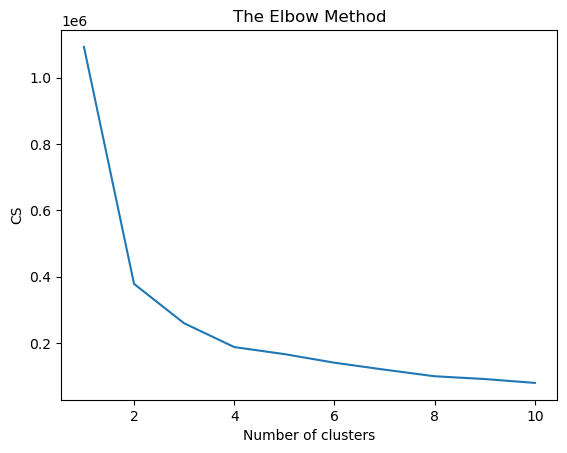

In [51]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_new_try)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [52]:
# y

In [53]:
# labels

In [54]:
kmeans = KMeans(n_clusters = 6,random_state=0, n_init="auto")
kmeans.fit(df_new_try)
labels = kmeans.labels_
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 16 out of 79 samples were correctly labeled.
Accuracy score: 0.20


In [55]:
# y
column_names = list(df_new_try.columns)
print(column_names)

['gmedian', 'rmedian', 'bmedian', 'gmean', 'rmean', 'bmean', 'gstd', 'rstd', 'bstd', 'isconvex', 'aspect_ratio_wh_s', 'extent_s', 'solidity', 'aspect_ratio_wh', 'extent', 'ratio_ell', 'is_cen_inside', 'is_mce_inside']


### Hierachical clustering

In [56]:
#Ward, complete, average, and single linkage
hierarchical_cluster1 = AgglomerativeClustering(linkage='ward', n_clusters=6)
labels_hc = hierarchical_cluster1.fit_predict(df_new_try)
print(labels_hc)
hierarchical_cluster2 = AgglomerativeClustering(linkage='complete', n_clusters=6)
labels_hc2 = hierarchical_cluster2.fit_predict(df_new_try)
print(labels_hc2)
# Single linkage doesn't work well 
hierarchical_cluster3 = AgglomerativeClustering(linkage='single', n_clusters=6)
labels_hc3 = hierarchical_cluster3.fit_predict(df_new_try)
print(labels_hc3)
hierarchical_cluster4 = AgglomerativeClustering(linkage='average', n_clusters=6)
labels_hc4 = hierarchical_cluster4.fit_predict(df_new_try)
print(labels_hc4)

[0 2 4 4 0 3 3 1 2 4 5 5 0 3 1 1 1 2 1 1 1 1 3 2 5 4 5 4 0 3 1 2 1 2 0 0 5
 1 5 0 5 1 0 1 1 2 3 3 0 1 2 5 3 3 1 2 4 0 1 3 2 1 2 4 5 1 1 3 3 2 1 2 1 1
 1 3 4 3 0]
[0 2 3 3 0 1 2 1 2 3 5 5 0 1 1 1 1 2 1 1 1 3 1 4 5 3 5 3 0 1 1 2 1 2 0 0 5
 1 5 0 5 1 0 1 1 2 1 1 0 1 2 5 2 2 1 2 3 0 1 1 2 1 2 3 5 3 1 1 1 2 1 2 1 1
 1 1 3 1 0]
[2 0 0 0 5 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 2 0 0 0 0 0 2 2 0
 0 0 2 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4]
[3 1 0 0 2 0 0 0 1 0 1 1 3 0 0 0 0 1 0 0 0 0 0 5 1 4 1 0 3 0 0 1 0 1 3 3 1
 0 1 3 1 0 3 0 0 1 0 0 3 0 1 1 0 0 0 1 0 3 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 2]


In [57]:
correct_labels1 = sum(y == labels_hc)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels1, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels1/float(y.size)))
correct_labels2 = sum(y == labels_hc2)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels2, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels2/float(y.size)))
correct_labels3 = sum(y == labels_hc3)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels3, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels3/float(y.size)))
correct_labels4 = sum(y == labels_hc4)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels4, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels4/float(y.size)))

Result: 15 out of 79 samples were correctly labeled.
Accuracy score: 0.19
Result: 14 out of 79 samples were correctly labeled.
Accuracy score: 0.18
Result: 38 out of 79 samples were correctly labeled.
Accuracy score: 0.48
Result: 29 out of 79 samples were correctly labeled.
Accuracy score: 0.37


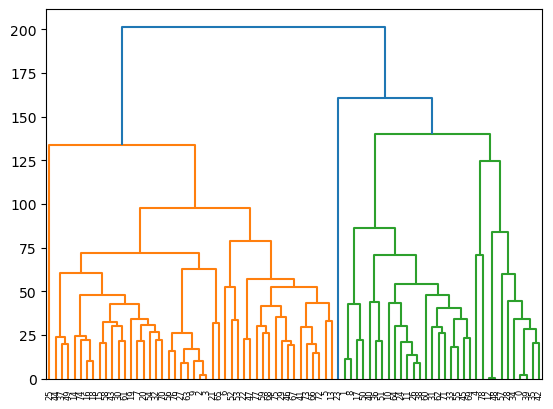

In [58]:
linkage_data = linkage(df_new_try, method='average', metric='euclidean')
dendrogram(linkage_data)
plt.show()

### DBSCAN

In [59]:
cluster_db = DBSCAN(eps = 5, min_samples = 2)
labels_db = cluster_db.fit_predict(df_new_try)
print(labels_db)
correct_labels_db = sum(y == labels_db)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_db, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_db/float(y.size)))

[ 0 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1]
Result: 2 out of 79 samples were correctly labeled.
Accuracy score: 0.03


### HDBSCAN

In [60]:
cluster_hdb = HDBSCAN(min_cluster_size = 2)
labels_hdb = cluster_hdb.fit_predict(df_new_try)
print(labels_hdb)
correct_labels_hdb = sum(y == labels_hdb)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels_hdb, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels_hdb/float(y.size)))


[ 3 14  8  8  0 -1 -1 19 14  8 -1 17  1 -1 10 21 10 15 10 -1 19  5  6 -1
 17 -1 17  9 -1 11 20 14 20 18 -1  4  2 16 17  3 -1 -1  4 -1 16 13 11  6
  1 16 15  2 -1 -1 19 18  7 -1 21 12 -1 20 14  9 -1  5 21 11 12 13 20 14
 21 21 10 11  7 -1  0]
Result: 2 out of 79 samples were correctly labeled.
Accuracy score: 0.03


## Supervised

### Decision tree

In [61]:
X = df_new_try
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

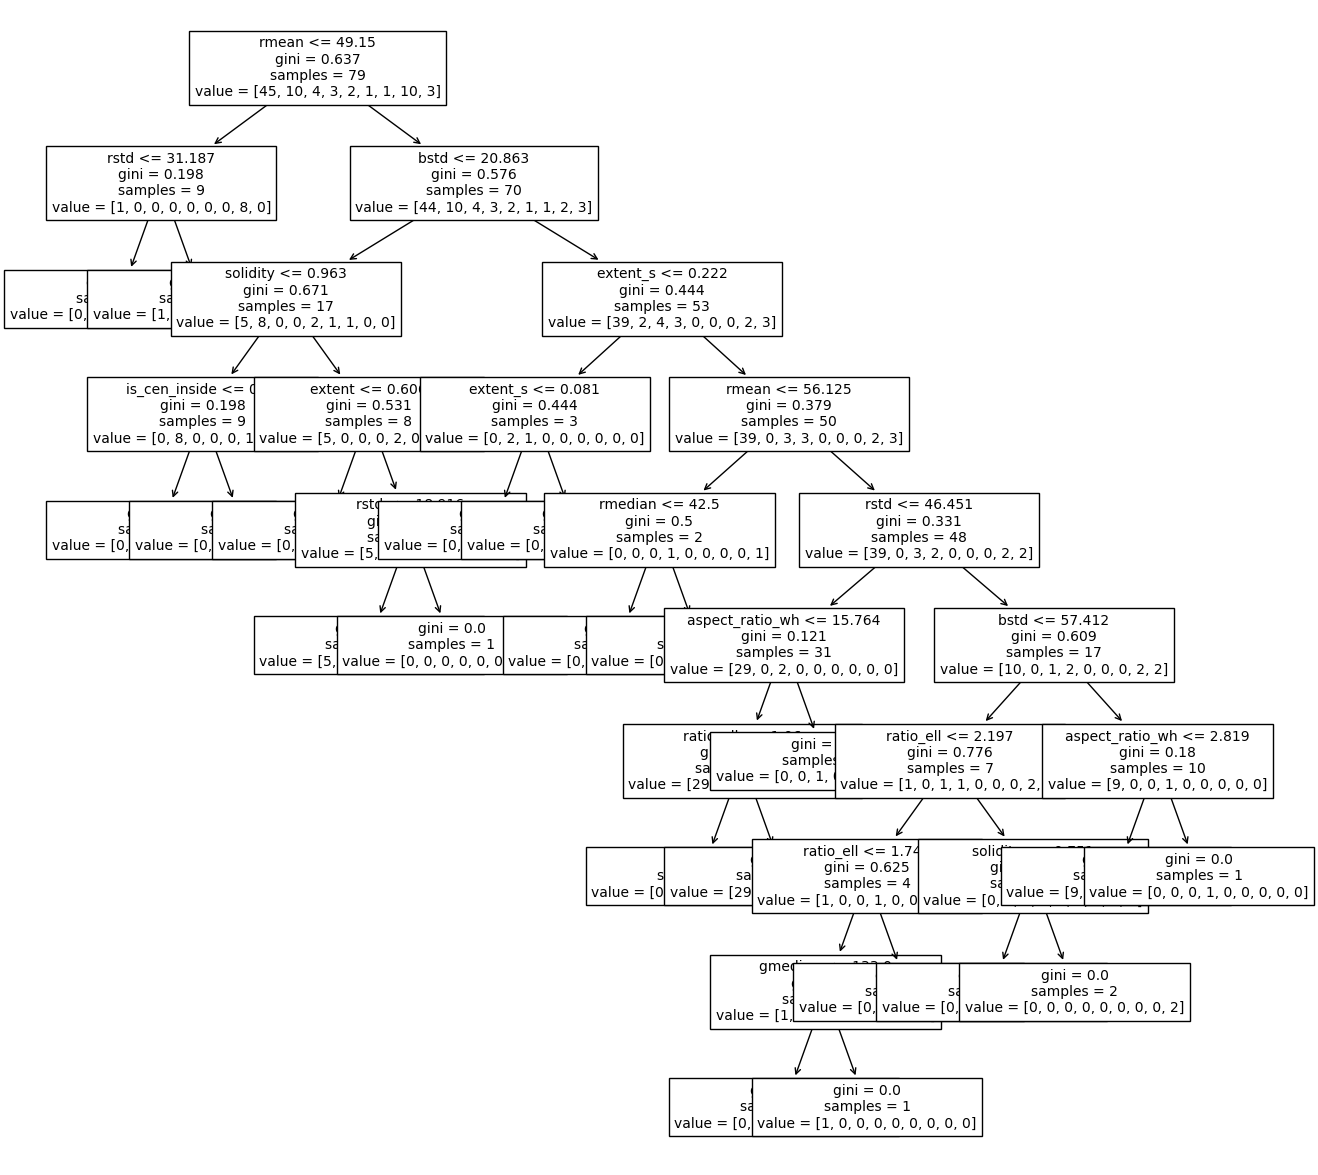

In [62]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
plt.figure(figsize=(15,15))
tree.plot_tree(dtree, feature_names = column_names, fontsize=10)
plt.show()

[7 1 0 0 1 7 3 0 1 0 7 0 7 0 1 3 2 7 0 7]
[0 0 0 0 0 7 0 0 1 0 8 0 1 8 0 6 1 4 0 0]
Train data accuracy: 1.0
Test data accuracy: 0.4


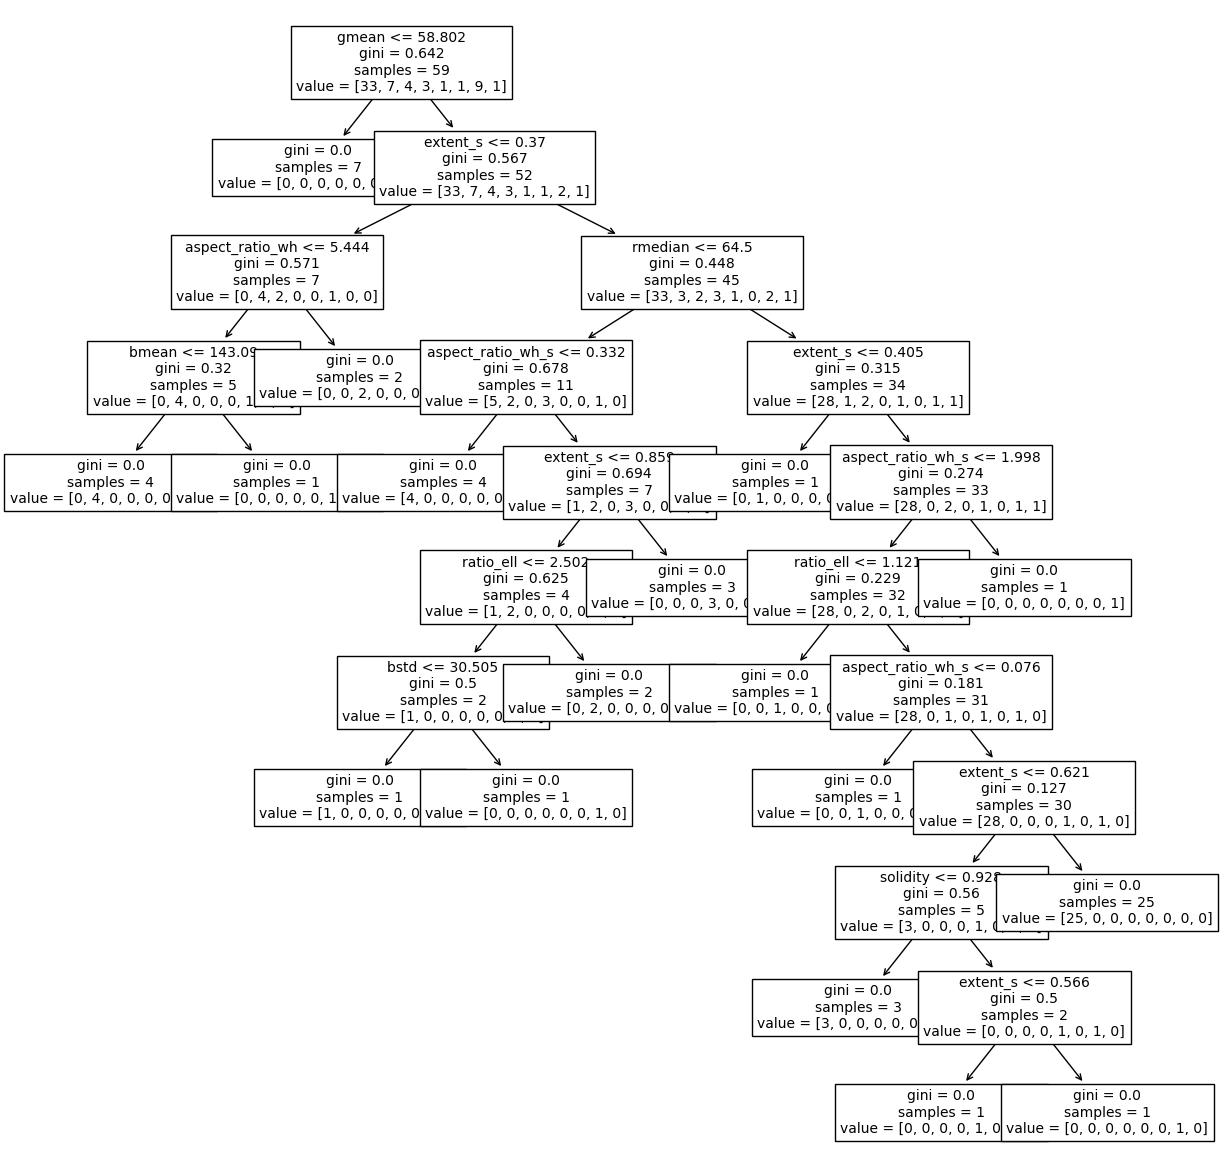

In [63]:
dtree = DecisionTreeClassifier(random_state = 2)
dtree.fit(X_train,y_train)

y_pred = dtree.predict(X_test)
print(y_pred)
print(y_test)
print("Train data accuracy:",accuracy_score(y_true = y_train, y_pred = dtree.predict(X_train)))
print("Test data accuracy:",accuracy_score(y_true = y_test, y_pred = y_pred))
plt.figure(figsize=(15,15))
tree.plot_tree(dtree, feature_names = column_names, fontsize=10)
plt.show()
# 0:billboard 1:building 2:infrastructure 3:road 4:sky 5:vegetation 

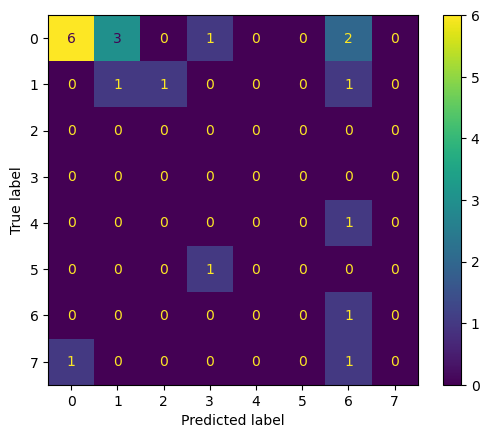

In [64]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()

In [65]:
dtree.classes_

array([0, 1, 2, 3, 4, 5, 7, 8])

In [66]:
print(f'class 0 accuracy: {confusion_matrix[0][0]/sum(confusion_matrix[0])}')
print(f'class 1 accuracy: {confusion_matrix[1][1]/sum(confusion_matrix[1])}')
print(f'class 2 accuracy: {confusion_matrix[2][2]/sum(confusion_matrix[2])}')
print(f'class 3 accuracy: {confusion_matrix[3][3]/sum(confusion_matrix[3])}')
print(f'class 4 accuracy: {confusion_matrix[4][4]/sum(confusion_matrix[4])}')
print(f'class 5 accuracy: {confusion_matrix[5][5]/sum(confusion_matrix[5])}')

class 0 accuracy: 0.5
class 1 accuracy: 0.3333333333333333
class 2 accuracy: nan
class 3 accuracy: nan
class 4 accuracy: 0.0
class 5 accuracy: 0.0


/sctmp/yelhe/ipykernel_1825962/412233397.py:3: RuntimeWarning: invalid value encountered in scalar divide
  print(f'class 2 accuracy: {confusion_matrix[2][2]/sum(confusion_matrix[2])}')
/sctmp/yelhe/ipykernel_1825962/412233397.py:4: RuntimeWarning: invalid value encountered in scalar divide
  print(f'class 3 accuracy: {confusion_matrix[3][3]/sum(confusion_matrix[3])}')


### Linear Regression

In [67]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 3)

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train2)

y_pred_lr = reg.predict(X_test2)


print('Coefficients: ', reg.coef_)
print('Variance score: {}'.format(reg.score(X_test2, y_test2)))

# # plot for residual error
# # # plt.style.use('fivethirtyeight')
# # plotting residual errors in training data
# plt.scatter(reg.predict(X_train2),
# 			reg.predict(X_train2) - y_train2,
# 			color="green", s=10,
# 			label='Train data')
# # plotting residual errors in test data
# plt.scatter(reg.predict(X_test2),
# 			reg.predict(X_test2) - y_test2,
# 			color="blue", s=10,
# 			label='Test data')
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)
# plt.legend(loc='upper right')
# plt.title("Residual errors")
# plt.show()
# plt.clf()
# plt.close()

Coefficients:  [ 4.27787915e-02 -1.84259288e-01  1.63540978e-01  1.26256945e-02
  1.42765569e-01 -2.06555520e-01 -8.51134520e-02  2.48104690e-02
  8.99806124e-02  1.99285033e-14  9.65049068e-01  1.04732094e+00
  5.39204117e+00  1.17572450e-01 -8.29267860e+00  1.02490639e-02
 -5.63791986e+00  9.90862818e-01]
Variance score: -0.41447070507792905


In [68]:
# from sklearn.preprocessing import PolynomialFeatures
# poly_reg2=PolynomialFeatures(degree=2)
# X_poly = poly_reg2.fit_transform(X)
# lin_reg_2 = linear_model.LinearRegression()
# lin_reg_2.fit(X_poly,y)
# y_pred_lr2 = lin_reg_2.predict(X_test)

# poly_reg3 = PolynomialFeatures(degree=3)
# X_poly3=poly_reg3.fit_transform(X)
# lin_reg_3=linear_model.LinearRegression()
# lin_reg_3.fit(X_poly3,y)
# y_pred_lr3 = lin_reg_3.predict(X_test)

# # plot for residual error
# plt.style.use('fivethirtyeight')
# # plotting residual errors in training data
# plt.scatter(lin_reg_2.predict(X_train),
# 			lin_reg_2.predict(X_train) - y_train,
# 			color="green", s=10,
# 			label='Train data')
# # plotting residual errors in test data
# plt.scatter(lin_reg_2.predict(X_test),
# 			lin_reg_2.predict(X_test) - y_test,
# 			color="blue", s=10,
# 			label='Test data')
# plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)
# plt.legend(loc='upper right')
# plt.title("Residual errors")
# plt.show()

### KNN

In [69]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 6)

neigh = KNeighborsClassifier(n_neighbors = 6)
neigh.fit(X_train1.values, y_train1)
y_pred_knn = neigh.predict(X_test1.values)

In [70]:
print(y_pred_knn)
print(y_test1)
print("Train data accuracy:",accuracy_score(y_true = y_train1, y_pred = neigh.predict(X_train1.values)))
print("Test data accuracy:",accuracy_score(y_true = y_test1, y_pred = y_pred_knn))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 7]
[0 3 8 6 1 0 0 0 1 1 0 0 0 1 7 1 0 1 0 7]
Train data accuracy: 0.6779661016949152
Test data accuracy: 0.55


[[9 0 0 0 0 0]
 [6 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 2 0]
 [1 0 0 0 0 0]]


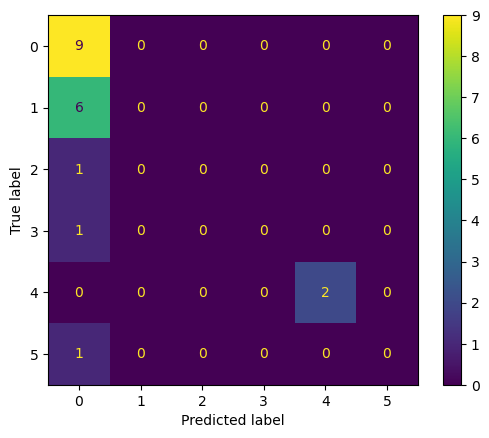

In [71]:
confusion_matrix_knn = metrics.confusion_matrix(y_test1, y_pred_knn)
print(confusion_matrix_knn)
cm_display_knn = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_knn)
cm_display_knn.plot()

In [72]:
print(f'class 0 accuracy: {confusion_matrix_knn[0][0]/sum(confusion_matrix_knn[0])}')
print(f'class 1 accuracy: {confusion_matrix_knn[1][1]/sum(confusion_matrix_knn[1])}')
print(f'class 2 accuracy: {confusion_matrix_knn[2][2]/sum(confusion_matrix_knn[2])}')
print(f'class 3 accuracy: {confusion_matrix_knn[3][3]/sum(confusion_matrix_knn[3])}')
print(f'class 4 accuracy: {confusion_matrix_knn[4][4]/sum(confusion_matrix_knn[4])}')
# print(f'class 5 accuracy: {confusion_matrix_knn[5][5]/sum(confusion_matrix_knn[5])}')

class 0 accuracy: 1.0
class 1 accuracy: 0.0
class 2 accuracy: 0.0
class 3 accuracy: 0.0
class 4 accuracy: 1.0


### Random Forest

In [73]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 7)
X_train3.shape, X_test3.shape


((55, 18), (24, 18))

In [74]:
rf = RandomForestClassifier(n_estimators = 6, random_state = 7)
rf.fit(X_train3, y_train3)
y_pred_rf = rf.predict(X_test3)

In [75]:
print(y_pred_rf)
print(y_test3)
print("Train data accuracy:",accuracy_score(y_true = y_train3, y_pred = rf.predict(X_train3)))
print("Test data accuracy:",accuracy_score(y_true = y_test3, y_pred = y_pred_rf))

[0 0 0 1 0 0 7 0 0 0 7 0 0 0 1 0 0 0 7 7 0 0 0 0]
[1 0 1 1 0 0 7 3 8 7 0 8 0 0 0 7 0 3 1 7 0 7 2 8]
Train data accuracy: 0.9272727272727272
Test data accuracy: 0.4166666666666667


[[7 1 0 0 1 0]
 [2 1 0 0 1 0]
 [1 0 0 0 0 0]
 [2 0 0 0 0 0]
 [3 0 0 0 2 0]
 [3 0 0 0 0 0]]


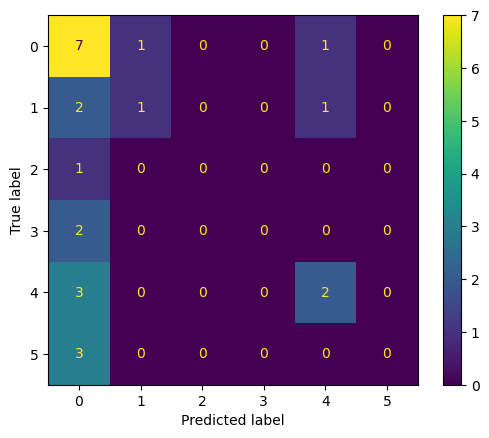

In [76]:
confusion_matrix_rf = metrics.confusion_matrix(y_test3, y_pred_rf)
print(confusion_matrix_rf)
cm_display_rf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf)
cm_display_rf.plot()

In [77]:
print(f'class 0 accuracy: {confusion_matrix_rf[0][0]/sum(confusion_matrix_rf[0])}')
print(f'class 1 accuracy: {confusion_matrix_rf[1][1]/sum(confusion_matrix_rf[1])}')
print(f'class 2 accuracy: {confusion_matrix_rf[2][2]/sum(confusion_matrix_rf[2])}')
print(f'class 3 accuracy: {confusion_matrix_rf[3][3]/sum(confusion_matrix_rf[3])}')
print(f'class 4 accuracy: {confusion_matrix_rf[4][4]/sum(confusion_matrix_rf[4])}')
# print(f'class 5 accuracy: {confusion_matrix_rf[5][5]/sum(confusion_matrix_rf[5])}')

class 0 accuracy: 0.7777777777777778
class 1 accuracy: 0.25
class 2 accuracy: 0.0
class 3 accuracy: 0.0
class 4 accuracy: 0.4


Text(0, 0.5, 'feature')

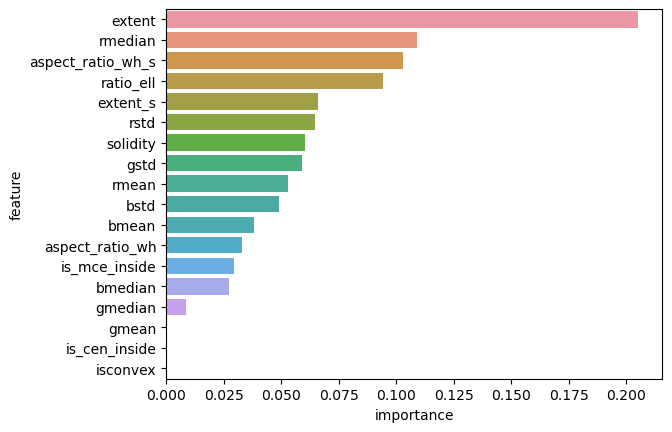

In [78]:
feature_name = list(df_new_try.columns.values.tolist())
importances = rf.feature_importances_
df_rf = pd.DataFrame({'features':feature_name, 'importances':importances})
df_rf.sort_values(by = ['importances'], ascending = False, inplace = True)
sn.barplot(x = df_rf['importances'], y = df_rf['features'])
plt.xlabel('importance')
plt.ylabel('feature')

### SVM

In [79]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 8)
X_train4.shape, X_test4.shape


((55, 18), (24, 18))

In [80]:
svmm = svm.SVC(random_state = 8, decision_function_shape = 'ovo')
svmm.fit(X_train4, y_train4)
y_pred_svm = svmm.predict(X_test4)

In [81]:
print(y_pred_svm)
print(y_test4)
print(svmm.classes_)
print("Train data accuracy:",accuracy_score(y_true = y_train4, y_pred = svmm.predict(X_train4)))
print("Test data accuracy:",accuracy_score(y_true = y_test4, y_pred = y_pred_svm))
print("Precision:",metrics.precision_score(y_true = y_test4, y_pred = y_pred_svm, 
                                           average = 'micro'))
print("Recall:",metrics.recall_score(y_true = y_test4, y_pred = y_pred_svm,
                                    average = 'micro'))

[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0]
[0 1 4 0 0 7 0 0 1 0 3 0 1 1 0 0 0 6 0 0 1 0 0 0]
[0 1 2 3 4 5 7 8]
Train data accuracy: 0.6727272727272727
Test data accuracy: 0.625
Precision: 0.625
Recall: 0.625


[[14  0  0  0  0  1]
 [ 5  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  1]]


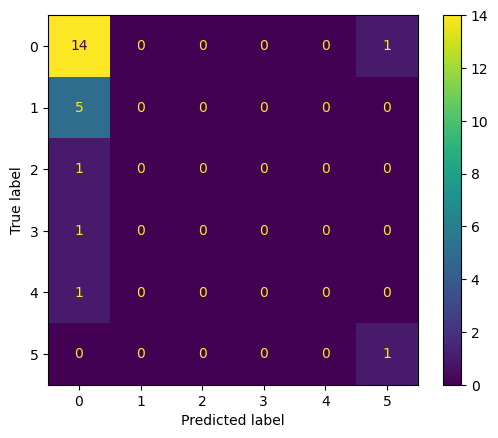

In [82]:
confusion_matrix_svm = metrics.confusion_matrix(y_test4, y_pred_svm)
print(confusion_matrix_svm)
cm_display_svm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svm)
cm_display_svm.plot()

In [83]:
print(f'class 0 accuracy: {confusion_matrix_svm[0][0]/sum(confusion_matrix_svm[0])}')
print(f'class 1 accuracy: {confusion_matrix_svm[1][1]/sum(confusion_matrix_svm[1])}')
print(f'class 2 accuracy: {confusion_matrix_svm[2][2]/sum(confusion_matrix_svm[2])}')
print(f'class 3 accuracy: {confusion_matrix_svm[3][3]/sum(confusion_matrix_svm[3])}')
print(f'class 4 accuracy: {confusion_matrix_svm[4][4]/sum(confusion_matrix_svm[4])}')
# print(f'class 5 accuracy: {confusion_matrix_svm[5][5]/sum(confusion_matrix_svm[5])}')

class 0 accuracy: 0.9333333333333333
class 1 accuracy: 0.0
class 2 accuracy: 0.0
class 3 accuracy: 0.0
class 4 accuracy: 0.0


### Correlation Matrix

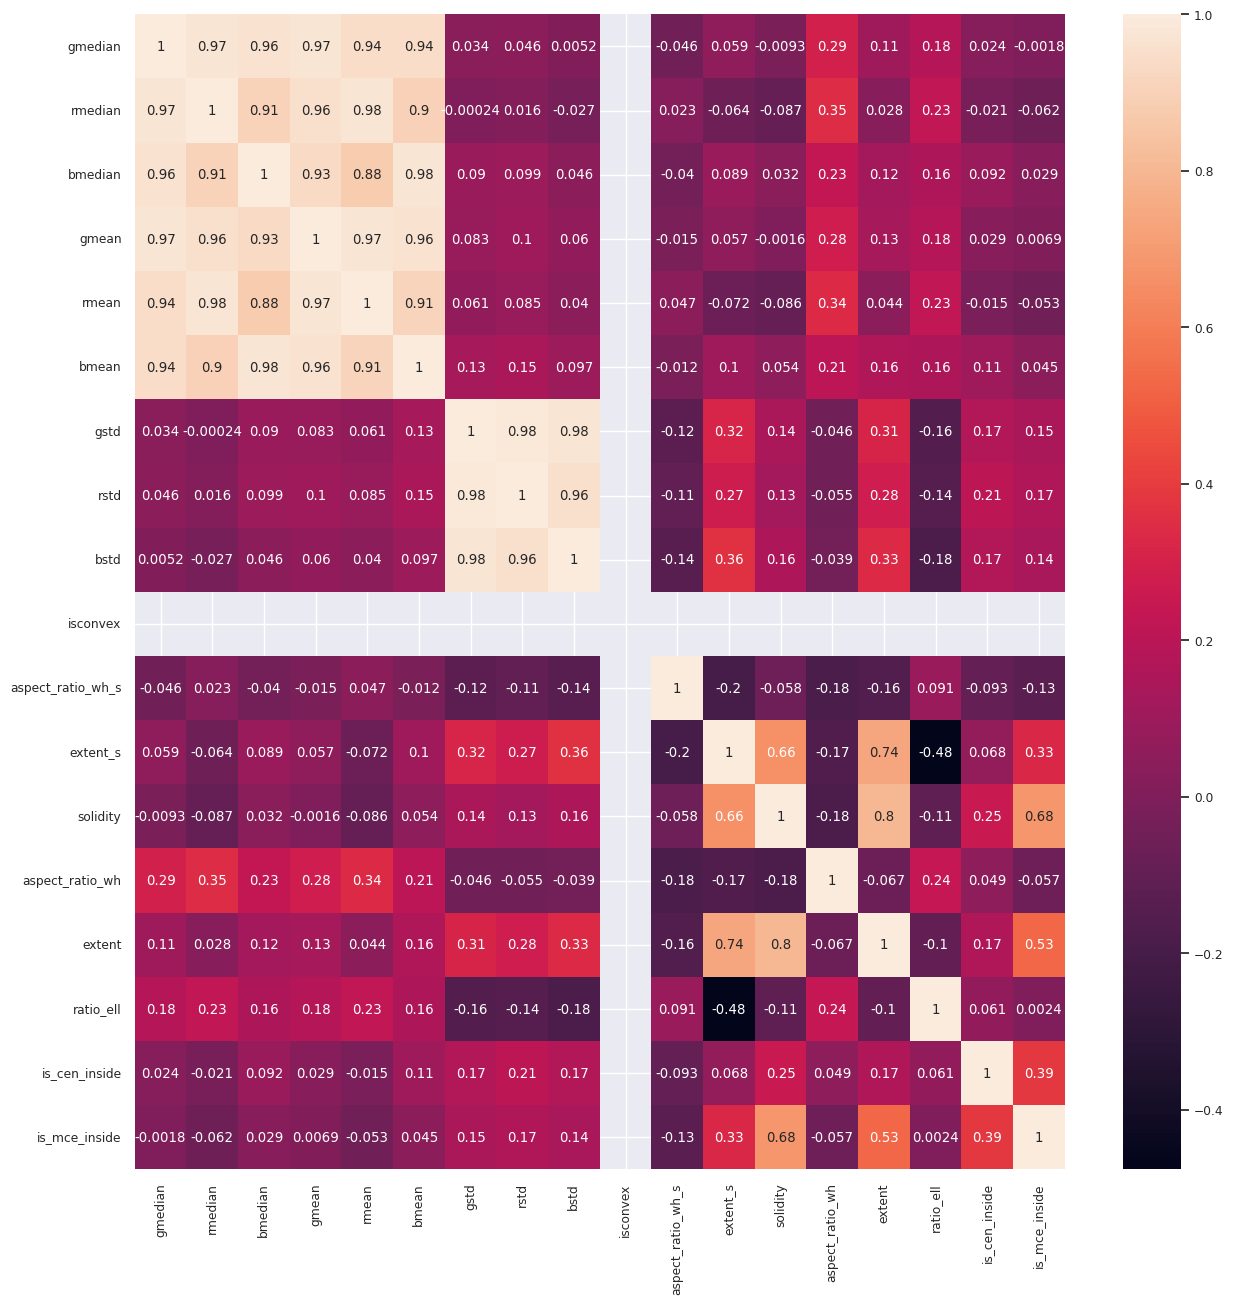

In [84]:


corr_matrix = df_new_try.corr()
plt.figure(figsize=(15,15))
sn.set(font_scale = 0.8)
sn.heatmap(corr_matrix, annot = True, )
plt.savefig('fig06_corrmat.png')
plt.show()